## Compare Different Matrix Completion Techniques
- Nuclear Norm Minimization
- Singular Value Thresholding
- Alternating Least Squares

Metrics: (under different % of matrix filled in)
- Accuracy
- Latency Time

In [1]:
from cvxpy import *


def nuclear_norm_solve(A, mask, mu=1.0):
    """
    Solve using a nuclear norm approach, using CVXPY.
    [ Candes and Recht, 2009 ]

    Parameters:
    -----------
    A : m x n array
        matrix we want to complete

    mask : m x n array
        matrix with entries zero (if missing) or one (if present)

    mu : float
        hyperparameter controlling tradeoff between nuclear norm and square loss

    Returns:
    --------
    X: m x n array
        completed matrix
    """
    X = Variable(shape=A.shape)
    objective = Minimize(mu * norm(X, "nuc") +
                         sum_squares(multiply(mask, X - A)))
    problem = Problem(objective, [])
    problem.solve(solver=SCS)
    return X.value


In [2]:
from sklearn.utils.extmath import randomized_svd, svd_flip
from scipy.sparse.linalg import svds
import numpy as np

def _my_svd(M, k, algorithm):
    if algorithm == 'randomized':
        (U, S, V) = randomized_svd(
            M, n_components=min(k, M.shape[1]-1), n_oversamples=20)
    elif algorithm == 'arpack':
        (U, S, V) = svds(M, k=min(k, min(M.shape)-1))
        S = S[::-1]
        U, V = svd_flip(U[:, ::-1], V[::-1])
    else:
        raise ValueError("unknown algorithm")
    return (U, S, V)

def svt_solve(
        A, 
        mask, 
        tau=None, 
        delta=None, 
        epsilon=1e-2,
        rel_improvement=-0.01,
        max_iterations=100,
        algorithm='arpack'):
    """
    Solve using iterative singular value thresholding.

    [ Cai, Candes, and Shen 2010 ]

    Parameters:
    -----------
    A : m x n array
        matrix to complete

    mask : m x n array
        matrix with entries zero (if missing) or one (if present)

    tau : float
        singular value thresholding amount;, default to 5 * (m + n) / 2

    delta : float
        step size per iteration; default to 1.2 times the undersampling ratio

    epsilon : float
        convergence condition on the relative reconstruction error

    max_iterations: int
        hard limit on maximum number of iterations

    Returns:
    --------
    X: m x n array
        completed matrix
    """
    Y = np.zeros_like(A)

    if not tau:
        tau = 5 * np.sum(A.shape) / 2
    if not delta:
        delta = 1.2 * np.prod(A.shape) / np.sum(mask)

    for _ in range(max_iterations):

        U, S, V = np.linalg.svd(Y, full_matrices=False)
        S = np.maximum(S - tau, 0)

        X = np.linalg.multi_dot([U, np.diag(S), V])
        Y += delta * mask * (A - X)

        recon_error = np.linalg.norm(mask * (X - A)) / np.linalg.norm(mask * A)
        # if _ % 1 == 0:
        #     print("Iteration: %i; Rel error: %.4f" % (_ + 1, recon_error))
        if recon_error < epsilon:
            break

    return X

In [38]:
def als(X, mask, rank=5, niters=100, lambda_=0.2):
    """
    Alternating Least Squares algorithm for matrix factorization
    X: matrix to factorize
    mask: binary mask of observed entries
    rank: rank of the factorization
    niters: number of iterations
    lambda_: regularization parameter
    """
    n, m = X.shape
    A = np.random.rand(n, rank)
    B = np.random.rand(m, rank)
    # X = X * mask
    for _ in range(niters):
        target = X + (1 - mask) * (np.dot(A, B.T))
        A = np.linalg.solve(np.dot(B.T, B) + lambda_ * np.eye(rank), np.dot(target, B).T).T
        # A[A < 0] = 0
        target = X + (1 - mask) * (np.dot(A, B.T))
        B = np.linalg.solve(np.dot(A.T, A) + lambda_ * np.eye(rank), np.dot(target.T, A).T).T
        # B[B < 0] = 0
    
    return np.dot(A, B.T)

In [4]:
import pandas as pd

matrix_df = pd.read_csv("dataset/job-matrix.csv", index_col='filename')
matrix = matrix_df.to_numpy()
matrix

array([[ 0.29350448,  0.28959751,  0.31358242, ...,  0.41022086,
         0.41022086,  1.76588845],
       [ 0.19951987,  0.19951987,  0.18966436, ...,  0.20183873,
         0.20183873,  1.51059127],
       [ 4.12188745,  4.12188745,  4.23523068, ...,  1.2749877 ,
         1.2749877 , 10.51367259],
       ...,
       [ 0.2518754 ,  0.2518754 ,  1.48206425, ...,  0.25155902,
         0.25155902,  1.7301929 ],
       [ 0.40899301,  0.40899301,  1.59373403, ...,  0.40235853,
         0.40235853,  5.18275762],
       [ 2.63003445,  2.63003445,  2.75869942, ...,  3.41951799,
         3.41951799,  7.70091581]])

In [42]:
def compute_mse(matrix, mask, completed_matrix):
    # print(np.sum(mask)/np.prod(mask.shape))
    return np.sum(np.square(mask * (matrix - completed_matrix))) / np.sum(mask), \
    np.sum(np.square((1 - mask) * (matrix - completed_matrix))) / np.sum(1 - mask)
    # return np.linalg.norm(mask * (matrix - completed_matrix)) / np.linalg.norm(mask * matrix)

In [35]:
init_mask = np.load("dataset/init_job_mask.npy")
print(init_mask.sum() / init_mask.size)

0.10962615134549394


In [47]:
mask_15 = np.logical_or(init_mask, np.random.rand(*matrix.shape) < 0.05)
print(mask_15.sum() / mask_15.size)
mask_20 = np.logical_or(mask_15, np.random.rand(*matrix.shape) < 0.06)
print(mask_20.sum() / mask_20.size)
mask_25 = np.logical_or(mask_20, np.random.rand(*matrix.shape) < 0.06)
print(mask_25.sum() / mask_25.size)
mask_30 = np.logical_or(mask_25, np.random.rand(*matrix.shape) < 0.07)
print(mask_30.sum() / mask_30.size)
masks = [init_mask, mask_15, mask_20, mask_25, mask_30]

0.15477695502979952
0.202275600505689
0.24887122990789237
0.30558063933538016


In [54]:
# # construct a low-rank matrix
# n, m = matrix.shape
# rank = 5
# U = np.random.rand(n, rank)
# V = np.random.rand(m, rank)
# matrix = np.dot(U, V.T)

In [52]:
import time
log_m = np.log1p(matrix)

find = False
while not find:
    mask_15 = np.logical_or(init_mask, np.random.rand(*matrix.shape) < 0.05)
    print(mask_15.sum() / mask_15.size)
    mask_20 = np.logical_or(mask_15, np.random.rand(*matrix.shape) < 0.06)
    print(mask_20.sum() / mask_20.size)
    mask_25 = np.logical_or(mask_20, np.random.rand(*matrix.shape) < 0.06)
    print(mask_25.sum() / mask_25.size)
    mask_30 = np.logical_or(mask_25, np.random.rand(*matrix.shape) < 0.07)
    print(mask_30.sum() / mask_30.size)
    masks = [init_mask, mask_15, mask_20, mask_25, mask_30]
    acc_20 = None
    acc_30 = None
    acc_25 = None
    for i in range(5):
        mask = masks[i]
        nuc_acc = []
        svt_acc = []
        als_acc = []
        nuc_time = []
        svt_time = []
        als_time = []
        m = mask * log_m
        for _ in range(10):
            # set a different random seed for each iteration
            # np.random.seed(_)
            
            start_time = time.time()
            nuc_m = nuclear_norm_solve(m, mask)
            end_time = time.time()
            pred_m = np.expm1(nuc_m)
            # print(compute_mse(matrix, mask, pred_m), end_time - start_time)
            nuc_acc.append(compute_mse(matrix, mask, pred_m)[1])
            if acc_20 is None and mask is mask_20:
                acc_20 = compute_mse(matrix, mask, pred_m)[1]
            if acc_25 is None and mask is mask_25:
                acc_25 = compute_mse(matrix, mask, pred_m)[1]
            if acc_30 is None and mask is mask_30:
                acc_30 = compute_mse(matrix, mask, pred_m)[1]
            
            nuc_time.append(end_time - start_time)
            start_time = time.time()
            svt_m = svt_solve(m, mask)
            end_time = time.time()
            pred_m = np.expm1(svt_m)
            # print(compute_mse(matrix, mask, pred_m), end_time - start_time)
            svt_acc.append(compute_mse(matrix, mask, pred_m)[1])
            svt_time.append(end_time - start_time)
            start_time = time.time()
            als_m = als(m, mask)
            end_time = time.time()
            pred_m = np.expm1(als_m)
            # print(compute_mse(matrix, mask, pred_m), end_time - start_time)
            als_acc.append(compute_mse(matrix, mask, pred_m)[1])
            als_time.append(end_time - start_time)
        print(i, np.mean(nuc_acc), np.mean(svt_acc), np.mean(als_acc), np.mean(nuc_time), np.mean(svt_time), np.mean(als_time))
    if acc_20 > acc_25 and acc_25 > acc_30 and acc_30 < 100:
        find = True

0.1544157486003251
0.2046234422972729
0.2468845945457829
0.30196857504063573


/var/folders/sr/6vwss26n2kz07f4659hh1lp80000gq/T/ipykernel_27669/3478864474.py:48: RuntimeWarning: overflow encountered in expm1
  pred_m = np.expm1(svt_m)
/var/folders/sr/6vwss26n2kz07f4659hh1lp80000gq/T/ipykernel_27669/1002953348.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.square(mask * (matrix - completed_matrix))) / np.sum(mask), \
/var/folders/sr/6vwss26n2kz07f4659hh1lp80000gq/T/ipykernel_27669/1002953348.py:4: RuntimeWarning: invalid value encountered in multiply
  np.sum(np.square((1 - mask) * (matrix - completed_matrix))) / np.sum(1 - mask)
/var/folders/sr/6vwss26n2kz07f4659hh1lp80000gq/T/ipykernel_27669/1002953348.py:4: RuntimeWarning: overflow encountered in square
  np.sum(np.square((1 - mask) * (matrix - completed_matrix))) / np.sum(1 - mask)


0 1075.227866685094 nan 1070.645650364983 0.6559434413909913 0.09644415378570556 0.015210652351379394
1 1121.9350343877836 1128.374324909177 1119.2343432597152 0.9530092477798462 0.10919890403747559 0.010769414901733398
2 1133.0034242461988 1182.6820914436605 1144.100113629532 0.7386034965515137 0.07083823680877685 0.009311437606811523
3 1190.153569120954 1225.8158255684064 1198.5114375047513 0.5686102390289307 0.1808692455291748 0.010796022415161134
4 17.31605068278961 35.81678428134397 22.412628626257487 0.466221022605896 0.0856508731842041 0.01024489402770996
0.15586057431822287
0.20353982300884957
0.25121907169947627
0.30449702004695683
0 1075.227866685094 nan 1069.9543034847575 0.6627950429916382 0.08625924587249756 0.00995309352874756
1 1123.3543906414964 4581.423343674083 1121.8145773090735 0.8540780782699585 0.1617659568786621 0.011829638481140136
2 49.40240343434699 68.68609266514241 51.56781889386224 0.8022900104522706 0.07849500179290772 0.011248373985290527
3 46.04320266776

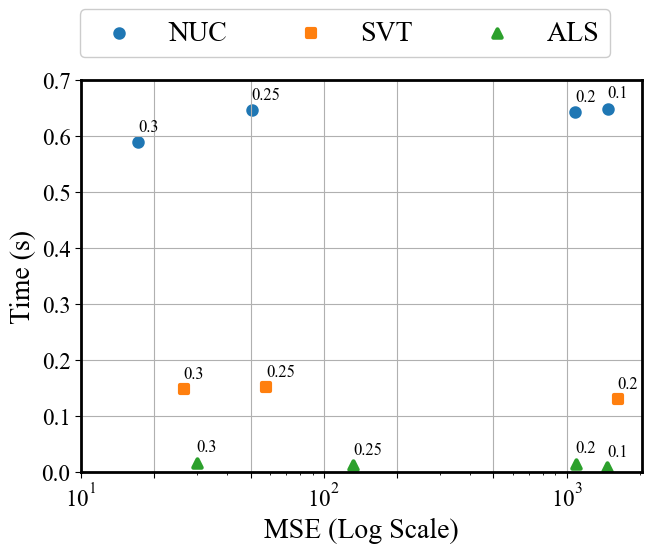

In [62]:
import matplotlib.pyplot as plt
linewidth=3
markersize=10
gridwidth=1.5
bwith=2
ticks_fontsize=16.5
label_fontsize=20
title_fontsize=25
fontweight='normal'
markeredgecolor = 'k'

fig, ax = plt.subplots(1,1,constrained_layout=True)
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)

# set font
plt.rcParams["font.family"] = "Times New Roman"

# scatter plot
# 0 1075.227866685094 nan 1070.6115907606318 0.6485761880874634 0.05670006275177002 0.00921647548675537
# 2 1187.176262998361 1257.1955528683975 1189.9192771005814 0.641760778427124 0.12944793701171875 0.015051436424255372
# 3 50.37892217929614 57.7891969473492 132.14969111417435 0.6456454038619995 0.1517488718032837 0.012449026107788086
# 4 17.239594646684598 126.47438866068794 3219.9535696392936 0.3894232511520386 0.14729275703430175 0.016576218605041503

nuc_acc = [1475.227866685094, 1087.176262998361, 50.37892217929614, 17.239594646684598]
svt_acc = [np.nan, 1623.8761665021518, 57.7891969473492, 26.47438866068794]
als_acc = [1470.6115907606318, 1089.9192771005814, 132.14969111417435, 29.9535696392936]

nuc_time = [0.6485761880874634, 0.641760778427124, 0.6456454038619995, 0.5894232511520386]
svt_time = [0.05670006275177002, 0.12944793701171875, 0.1517488718032837, 0.14729275703430175]
als_time = [0.00921647548675537, 0.015051436424255372, 0.012449026107788086, 0.016576218605041503]

p = [0.1, 0.2, 0.25, 0.3]
# scatter plot
ax.scatter(nuc_acc, nuc_time, label='NUC', linewidth=linewidth, marker='o')
ax.scatter(svt_acc, svt_time, label='SVT', linewidth=linewidth, marker='s')
ax.scatter(als_acc, als_time, label='ALS', linewidth=linewidth, marker='^')
for i, txt in enumerate(p):
    ax.annotate(txt, (nuc_acc[i] + 0.02, nuc_time[i] + 0.02), fontsize=12)
    ax.annotate(txt, (svt_acc[i]+ 0.02, svt_time[i]+ 0.02), fontsize=12)
    ax.annotate(txt, (als_acc[i]+ 0.02, als_time[i]+ 0.02), fontsize=12)
ax.set_xlabel('MSE (Log Scale)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_ylabel('Time (s)', fontsize=label_fontsize, fontweight=fontweight)

ax.set_xscale('log')
ax.set_xticks([10, 20, 50, 100, 200, 500, 1000])
ax.set_ylim(0, 0.7)
ax.grid('--')
fig.legend(framealpha=1,fontsize=label_fontsize, loc='upper center',ncol=3, bbox_to_anchor=(0.53, 1.15))
plt.show()

fig.savefig('fig/mc.pdf', bbox_inches='tight')